# Image classification: cats & dogs

In [1]:
# Handle imports up-front
import glob
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image


2024-11-20 21:47:32.993407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Set the path to the training data
training_data_path='../data/train'

# Get a list of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dog/dog.*')
training_cats=glob.glob(f'{training_data_path}/cat/cat.*')

### 1.2. Inspect

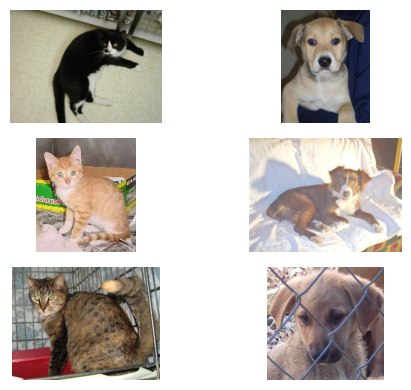

In [3]:
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [ ]:
# Load one of the dogs
dog=image.load_img(training_dogs[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog=image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (500, 390, 3)


The data has shape of 500 x 390 x 3? So, the image is 500 x 390 pixels, but what is the 3? Let's plot the pixel values and you will see what is going on:

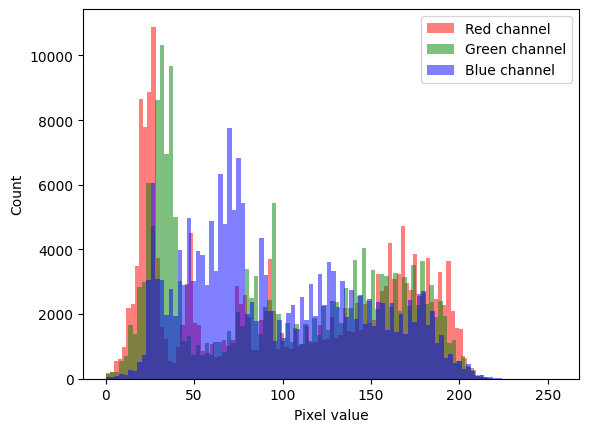

In [5]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

There are a few interesting observations we can make here:

1. This array has 3 axes: 500 x 390 x 3. The first two are the dimensions of the image, the third is the three color channels: red, green and blue
2. 500 x 390 x 3 is over a half million individual values - this one image is 10 time more data that any of the other datasets we have worked with so far!
3. The range of pixel values is from 0 to about 250 - in reality it is (0,255) for a total range of 256 values per pixel. This is defined by the JPEG image standard.

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

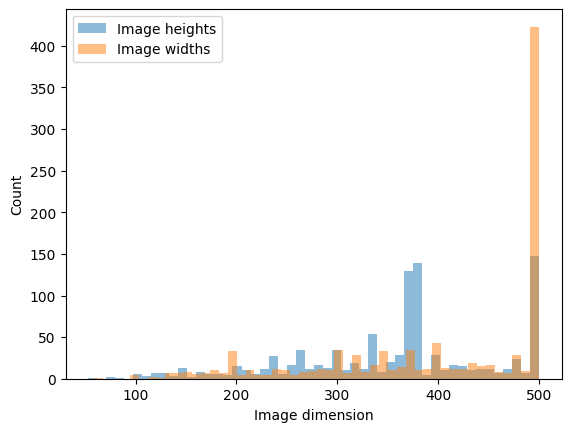

In [6]:
sample_size=1000
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

heights=[]
widths=[]

for sample_image in sample:

    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Based on the above plot, let's set our image dimension at 128x128.

In [ ]:
image_dim=128

### 2.3. Image aspect ratios

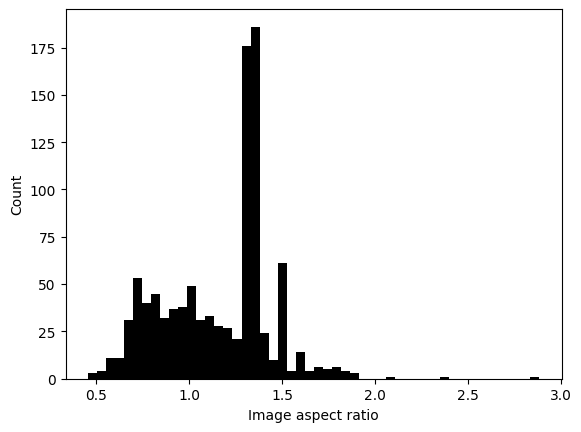

In [8]:
aspect_ratios=np.array(widths)/np.array(heights)

plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

## 2. Model

### 2.1. Prepare images for streaming

In [9]:
def make_datasets(training_data_path: str, image_dim: int, batch_size: int=32):

    training_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_dim, image_dim),
        color_mode='grayscale',
        batch_size=batch_size
    ).repeat()

    validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_dim, image_dim),
        color_mode='grayscale',
        batch_size=batch_size
    ).repeat()

    return training_dataset, validation_dataset

training_dataset, validation_dataset=make_datasets(training_data_path, image_dim)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### 2.1. Model definition

In [10]:
def compile_model(image_dim, learning_rate):

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_dim, image_dim, 1)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model

model=compile_model(image_dim, 0.001)
model.summary()

2024-11-20 21:48:20.912009: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-11-20 21:48:20.971530: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-11-20 21:48:20.985536: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,161 (32.09 MB)

 Trainable params: 8,412,161 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

### 2.2. Model training

In [11]:
training_results=model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=10,
  steps_per_epoch=5,
  validation_steps=5
)

Epoch 1/10


2024-11-20 21:48:22.437949: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-11-20 21:48:22.500502: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - binary_accuracy: 0.5286 - loss: 0.9659 - val_binary_accuracy: 0.5188 - val_loss: 0.6920
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - binary_accuracy: 0.4641 - loss: 0.7322 - val_binary_accuracy: 0.5625 - val_loss: 0.6904
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - binary_accuracy: 0.5569 - loss: 0.6912 - val_binary_accuracy: 0.4688 - val_loss: 0.6941
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - binary_accuracy: 0.4877 - loss: 0.6922 - val_binary_accuracy: 0.5312 - val_loss: 0.6894
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - binary_accuracy: 0.4870 - loss: 0.6950 - val_binary_accuracy: 0.4625 - val_loss: 0.6922
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.4879 - loss: 0.6921 - val_binary_accuracy: 0.4875 - val_loss: 0.6927
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - binary_accuracy: 0.5100 - loss: 0.6929 - val_binary_accuracy: 0.5375 - val_loss: 0.6915
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step 

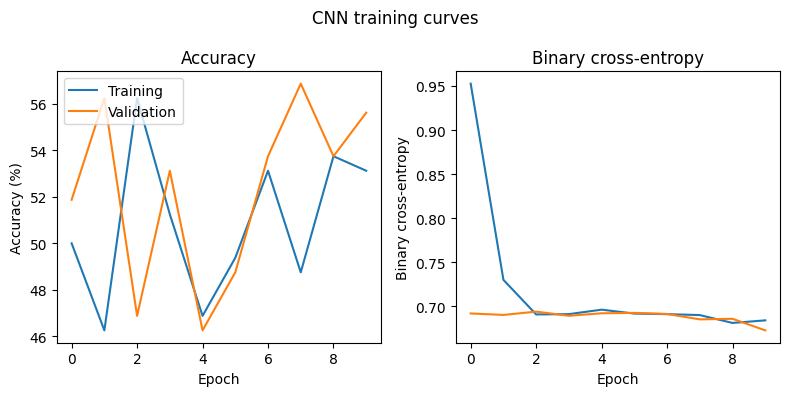

In [12]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
plt.tight_layout()
plt.show()

### 2.3. Model optimization

In [ ]:
learning_rates=[0.001,0.00001]
batch_sizes=[32,128]
training_results=[]

conditions=list(itertools.product(batch_sizes, learning_rates))

for i, parameters in enumerate(conditions):

    batch_size, learning_rate=parameters

    print(f'\nStarting training run {i + 1} of {len(learning_rates) * len(batch_sizes)}: batch size: {batch_size}, learning rate: {learning_rate}')

    training_dataset, validation_dataset=make_datasets(training_data_path, image_dim, batch_size)
    model=compile_model(image_dim, learning_rate)

    early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

    training_result=model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=10,
        steps_per_epoch=5,
        validation_steps=5,
        callbacks=[early_stopping]
    )

    training_results.append(training_result)


Starting training run 1 of 9: batch size: 32, learning rate: 0.001
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - binary_accuracy: 0.5286 - loss: 0.9659 - val_binary_accuracy: 0.5188 - val_loss: 0.6920
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.4641 - loss: 0.7322 - val_binary_accuracy: 0.5625 - val_loss: 0.6904
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.5569 - loss: 0.6912 - val_binary_accuracy: 0.4688 - val_loss: 0.6941
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.4877 - loss: 0.6922 - val_binary_accuracy: 0.5312 - val_loss: 0.6894
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.4870 - loss: 0.6950 - val_binary_accuracy: 0.4625 - val_loss: 0.6922
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - binary_accuracy: 0.4879 - loss: 0.6921 - val_bin

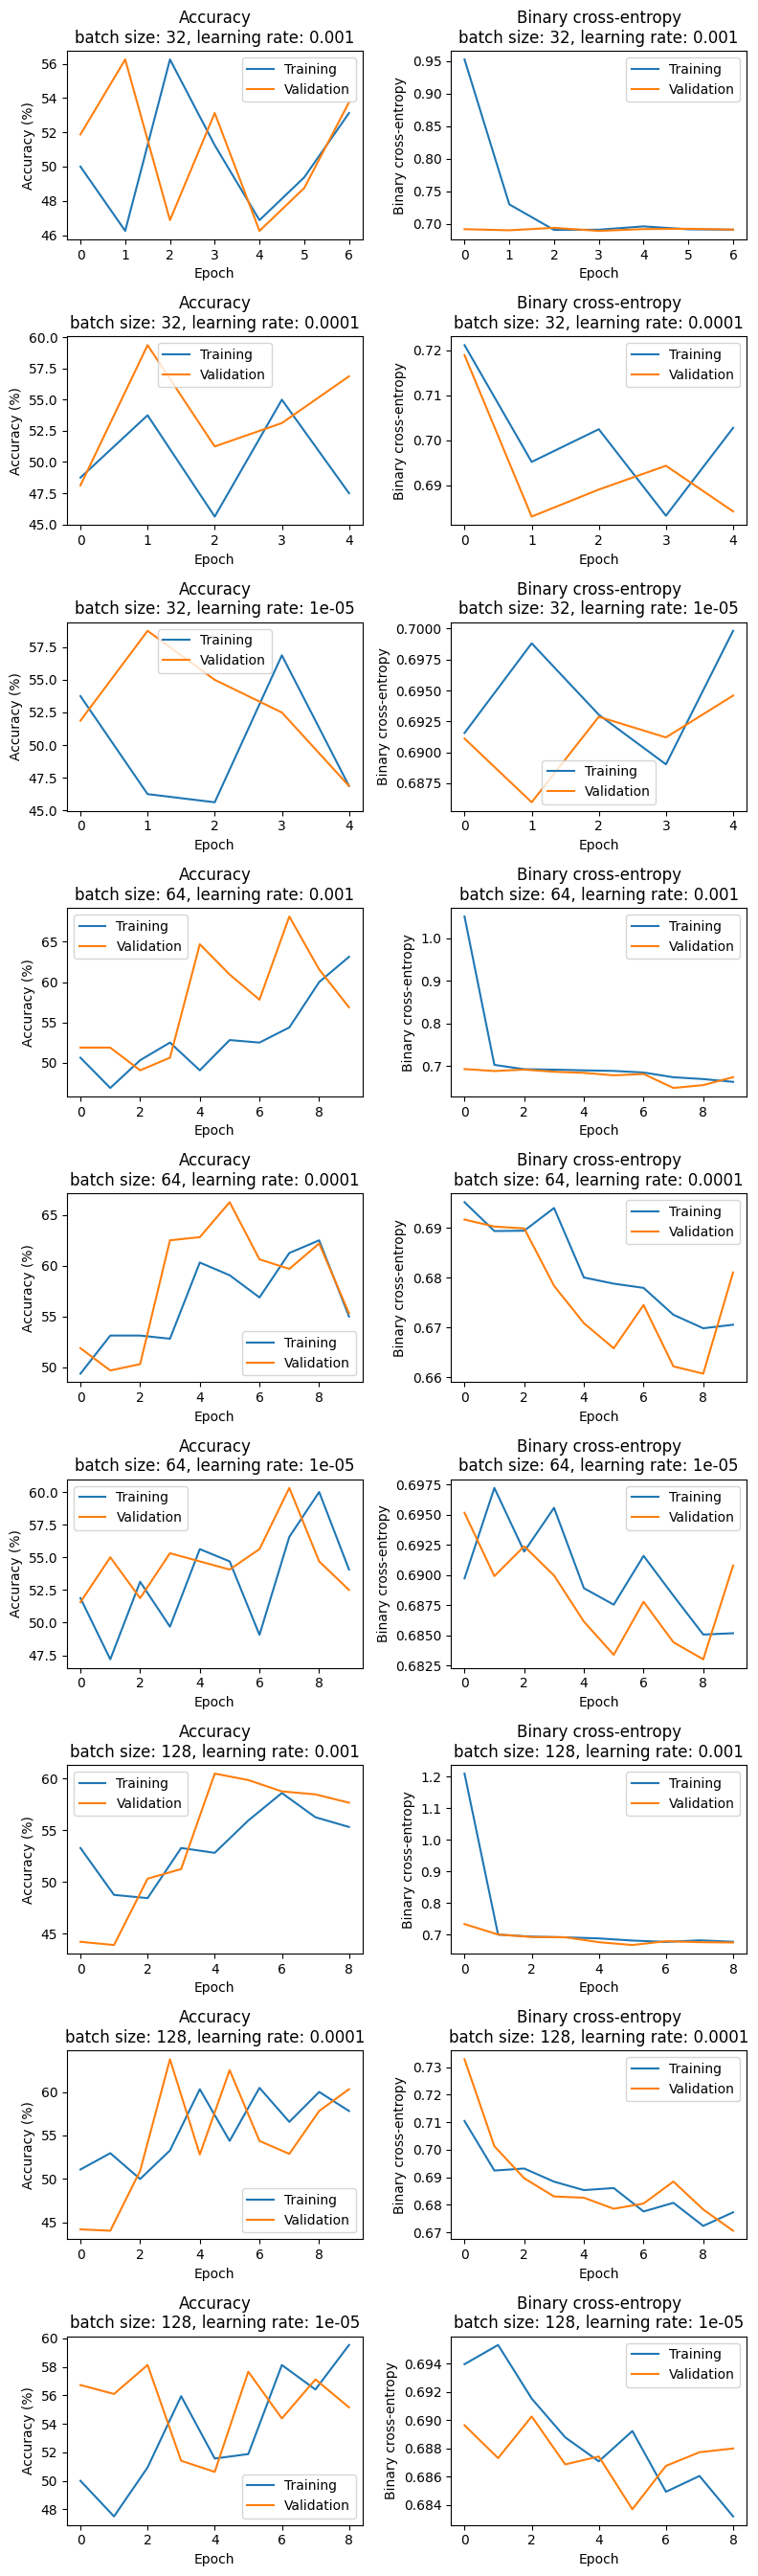

: 

In [ ]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(len(training_results), 2, figsize=(8,3*len(training_results)))

# Plot the results of each training run
for i, parameters in enumerate(conditions):
    batch_size, learning_rate=parameters
    training_result=training_results[i]

    # Plot training and validation accuracy
    axs[i,0].set_title(f'Accuracy\nbatch size: {batch_size}, learning rate: {learning_rate}')
    axs[i,0].plot(np.array(training_result.history['binary_accuracy']) * 100, label='Training')
    axs[i,0].plot(np.array(training_result.history['val_binary_accuracy']) * 100, label='Validation')
    axs[i,0].set_xlabel('Epoch')
    axs[i,0].set_ylabel('Accuracy (%)')
    axs[i,0].legend(loc='best')

    # Plot training and validation binary cross-entropy
    axs[i,1].set_title(f'Binary cross-entropy\nbatch size: {batch_size}, learning rate: {learning_rate}')
    axs[i,1].plot(training_result.history['loss'], label='Training')
    axs[i,1].plot(training_result.history['val_loss'], label='Validation')
    axs[i,1].set_xlabel('Epoch')
    axs[i,1].set_ylabel('Binary cross-entropy')
    axs[i,1].legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()

From the training curves, it looks like the best results are obtained with a batch size fo 256 and a learning rate of 0.001. We can also try running more steps per epoch and more validation steps. That will slow the training down, but may help smooth the curves out somewhat. Let's use those settings and train the model for longer.

In [ ]:
batch_size=128
learning_rate=0.001
epochs=100
steps_per_epoch=20
validation_steps=10

training_dataset, validation_dataset=make_datasets(training_data_path, image_dim, batch_size)
model=compile_model(image_dim, learning_rate)

early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

training_result=model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Epoch 1/100


In [ ]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_result.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_result.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_result.history['loss'])
axs[1].plot(training_result.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
plt.tight_layout()
plt.show()